In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import rcParams
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [149]:
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 12, 5

In [150]:
df = pd.read_csv("data.csv")

In [151]:
rt_bc = df.loc[df['rxtx'] == True]
bc_rt = df.loc[df['rxtx'] == False]

In [152]:
counts = list(df['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')
data_a = counts.to_frame()

In [153]:
counts = list(rt_bc['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')
data_r = counts.to_frame()

In [154]:
counts = list(bc_rt['count'])
counts = pd.Series(counts, index=pd.date_range('1-1-1959', periods=len(counts), freq='D'), name = 'value')
data_b = counts.to_frame()

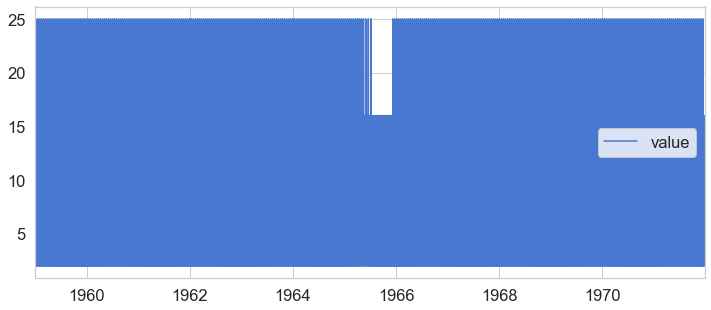

In [155]:
data_b.plot()

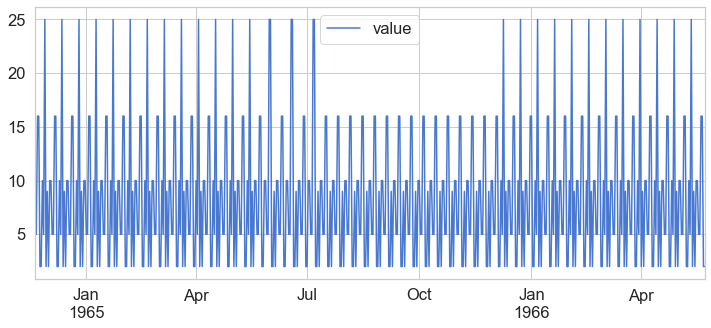

In [156]:
data_b[2150:2700].plot()

In [143]:
train = data_b[:2149] 
test = data_b[2150:2700]

In [144]:
len(test)

550

In [145]:
# Standarize the `value` column
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

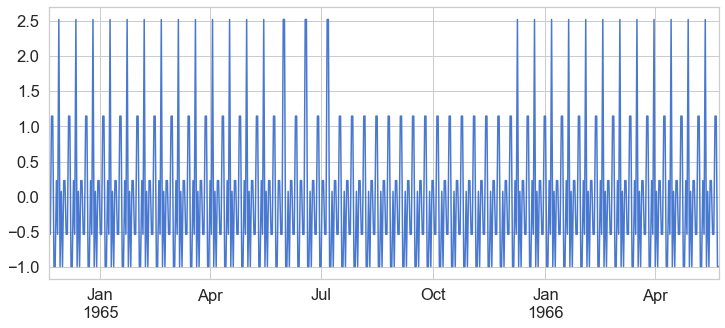

In [146]:
test['value'].plot()

In [147]:
test

,value
1964-11-20,-0.535781
1964-11-21,-0.535781
1964-11-22,1.147320
1964-11-23,1.147320
1964-11-24,-0.994809
...,...
1966-05-19,-0.535781
1966-05-20,1.147320
1966-05-21,1.147320
1966-05-22,-0.994809


In [157]:
# Helper function to create windows of data of length `time_steps`
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [158]:
TIME_STEPS = 3

# Use the helper function to reshape the data to [samples, time_steps, n_features]
X_train, y_train = create_dataset(
                                      train[['value']],
                                      train.value,
                                      TIME_STEPS
                                 )

X_test, y_test = create_dataset(
                                    test[['value']],
                                    test.value,
                                    TIME_STEPS
                               )

print(X_train.shape)

(2146, 3, 1)


In [159]:
X_test

array([[[-0.53578144],
        [-0.53578144],
        [ 1.14731989]],

       [[-0.53578144],
        [ 1.14731989],
        [ 1.14731989]],

       [[ 1.14731989],
        [ 1.14731989],
        [-0.99480908]],

       ...,

       [[-0.53578144],
        [-0.53578144],
        [ 1.14731989]],

       [[-0.53578144],
        [ 1.14731989],
        [ 1.14731989]],

       [[ 1.14731989],
        [ 1.14731989],
        [-0.99480908]]])

In [160]:
X_test.shape

(547, 3, 1)

In [161]:
mytest = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [162]:
mytest.shape

(547, 1, 3)

In [163]:
mytest

array([[[-0.53578144, -0.53578144,  1.14731989]],

       [[-0.53578144,  1.14731989,  1.14731989]],

       [[ 1.14731989,  1.14731989, -0.99480908]],

       ...,

       [[-0.53578144, -0.53578144,  1.14731989]],

       [[-0.53578144,  1.14731989,  1.14731989]],

       [[ 1.14731989,  1.14731989, -0.99480908]]])

In [126]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [127]:
print(X_train.shape)

(2146, 1, 3)


In [128]:
X_train_pred.shape

(2119, 1, 30)

In [129]:
print(X_test.shape)

(547, 1, 3)


In [134]:
X_test_pred.shape

(520, 1, 30)

In [131]:
# LSTM Autoencoder Model 
def create_model(learning_rate):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(
        units=64,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
    model.add(keras.layers.LSTM(units=64, return_sequences=True))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(
      keras.layers.TimeDistributed(
        keras.layers.Dense(units=X_train.shape[2])
      )
    )

    optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=0.8)

    # Loss used in the guide is MAE. RMSE would penalize large errors more. Possible future research.
    model.compile(loss='mae', optimizer=optimizer)
    return model

In [132]:
LEARNING_RATE = .01
model = create_model(LEARNING_RATE)
history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        shuffle=False,
    )


Train on 1931 samples, validate on 215 samples
Epoch 1/100
1931/1931 [==============================] - 2s 1ms/sample - loss: 0.7969 - val_loss: 0.8016
Epoch 2/100
1931/1931 [==============================] - 0s 97us/sample - loss: 0.7969 - val_loss: 0.8018
Epoch 3/100
1931/1931 [==============================] - 0s 89us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 4/100
1931/1931 [==============================] - 0s 87us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 5/100
1931/1931 [==============================] - 0s 87us/sample - loss: 0.7969 - val_loss: 0.8016
Epoch 6/100
1931/1931 [==============================] - 0s 88us/sample - loss: 0.7969 - val_loss: 0.8018
Epoch 7/100
1931/1931 [==============================] - 0s 87us/sample - loss: 0.7969 - val_loss: 0.8017
Epoch 8/100
1931/1931 [==============================] - 0s 88us/sample - loss: 0.7969 - val_loss: 0.8018
Epoch 9/100
1931/1931 [==============================] - 0s 88us/sample - loss: 0.7969 - val_loss: 0.8017


1931/1931 [==============================] - 0s 89us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 78/100
1931/1931 [==============================] - 0s 86us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 79/100
1931/1931 [==============================] - 0s 94us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 80/100
1931/1931 [==============================] - 0s 91us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 81/100
1931/1931 [==============================] - 0s 90us/sample - loss: 0.7969 - val_loss: 0.8022
Epoch 82/100
1931/1931 [==============================] - 0s 88us/sample - loss: 0.7969 - val_loss: 0.8024
Epoch 83/100
1931/1931 [==============================] - 0s 87us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 84/100
1931/1931 [==============================] - 0s 86us/sample - loss: 0.7969 - val_loss: 0.8024
Epoch 85/100
1931/1931 [==============================] - 0s 85us/sample - loss: 0.7969 - val_loss: 0.8023
Epoch 86/100
1931/1931 [==========================

In [ ]:
# Save/Load Model to/from Disk

model_json = model.to_json()
with open("model.02.json", "w") as json_file:
    json_file.write(model_json)
# Serialize network weights to HDF5
model.save_weights("model.02.h5")
print("Saved model to disk")

# Saved model to disk
with open("model.02.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = keras.models.model_from_json(loaded_model_json)


# load weights into new model
loaded_model.load_weights("model.02.h5")
print("Loaded model from disk")
#Loaded model from disk
print(f"Saved model matches trained model: {model.get_config() == loaded_model.get_config()}")
#Saved model matches trained model: True

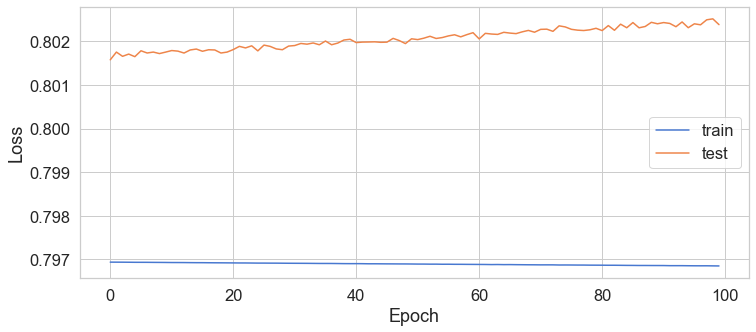

In [133]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

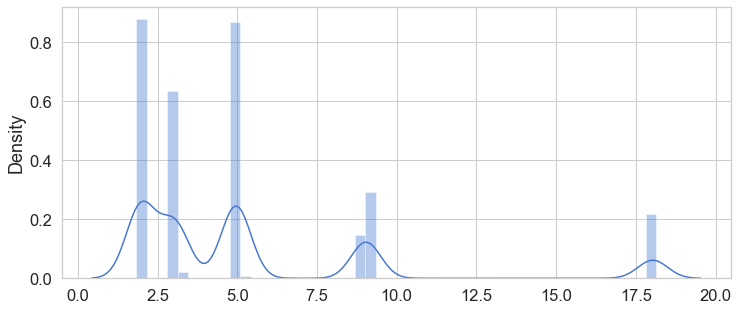

In [94]:
# Prediction

X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True);

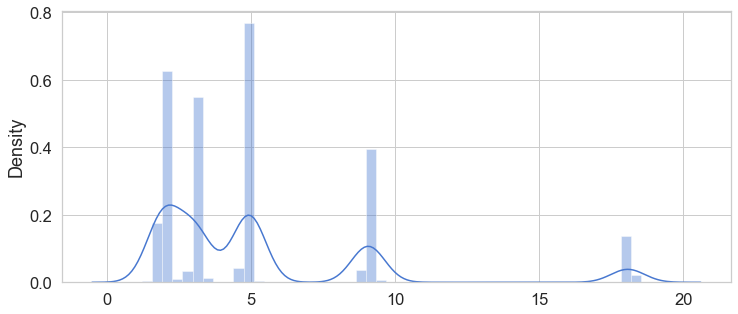

In [95]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(test_mae_loss, bins=50, kde=True)

In [45]:
X_test_pred.shape

(520, 1, 30)

In [56]:
len(X_test_pred)

520

In [122]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([y_test])


In [139]:
test_predict.shape

(520, 1, 30)

In [140]:
520*30

15600

In [141]:
#Scaling
from sklearn.preprocessing import MinMaxScaler
## Prediction
scalar = MinMaxScaler(feature_range=(-10, 10))
#predict_y = scaler(predict_y)

scalar.fit(test_predict.reshape(520, 1, 30))
test_predict = scalar.transform(test_predict.reshape(520, 1, 30))

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

ValueError: x and y must have same first dimension, but have shapes (200,) and (500,)

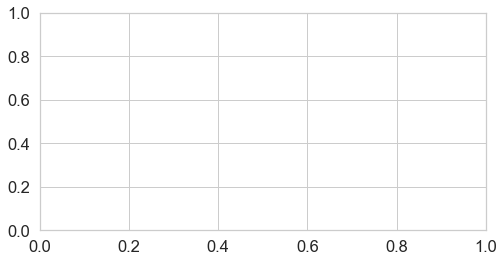

In [164]:

aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:500], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:500], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [44]:
test_score_df = pd.DataFrame(index=test.iloc[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
# test_score_df['anomaly'] = test_score_df.loss < test_score_df.threshold
test_score_df['value'] = test.iloc[TIME_STEPS:].value

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend()
plt.show()

ValueError: Wrong number of items passed 30, placement implies 1

In [60]:
plt.plot(
    test.value.iloc[TIME_STEPS:].index, 
    scaler.inverse_transform(test.iloc[TIME_STEPS:].value),
    alpha=0.6
)


NameError: name 'scaler' is not defined